# Train CNN with MFCCs


Inspired by https://medium.com/@diego-rios/speech-emotion-recognition-with-convolutional-neural-network-ae5406a1c0f7


Import the necessary libraries


In [1]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchview import draw_graph
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import os
import sys
import numpy as np
import random
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.1.1+cu118
True


Set the seed for reproducibility


In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings


In [5]:
MODEL = 'cnn_mfccs'

train_csv = '../../../data/mfcc_train_dataset.csv'
test_csv = '../../../data/mfcc_test_dataset.csv'
val_csv = '../../../data/mfcc_val_dataset.csv'
root_dir = '../../../data/'
class_weights_path = '../../../data/class_weights.pt'

Custom dataset class for loading the mfcc tensors


In [6]:
from datasets.MfccDataset import MFCCDataset

Define the training function


In [7]:
def train(model, trainloader, criterion, optimizer, device):
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    # train mode
    model.train()

    epoch_start = time.time()
    pbar = tqdm(enumerate(trainloader), total=len(
        trainloader), desc="Training")

    for i, (inputs, labels) in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update training loss
        train_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # Calculate time metrics
        elapsed = time.time() - epoch_start
        progress = (i + 1) / len(trainloader)
        eta = elapsed / progress - elapsed

        # Update progress bar with current loss and ETA
        pbar.set_postfix({
            "Loss": f"{loss.item()}",
            "Elapsed": f"{elapsed:.4f}s",
            "ETA": f"{eta:.4f}s"
        })

    train_loss = train_loss / len(trainloader)
    train_accuracy = train_correct / train_total * 100

    return model, train_loss, train_accuracy

Define the validation function


In [8]:
def validate(model, valloader, criterion, device):
    val_loss = 0.0
    val_total = 0
    val_correct = 0

    # Switch to evaluation mode
    model.eval()

    epoch_start = time.time()
    pbar = tqdm(enumerate(valloader), total=len(
        valloader), desc="Validating")

    with torch.no_grad():
        for i, (inputs, labels) in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update test loss
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            # Calculate time metrics
            elapsed = time.time() - epoch_start
            progress = (i + 1) / len(valloader)
            eta = elapsed / progress - elapsed

            # Update progress bar with current loss and ETA
            pbar.set_postfix({
                "Loss": f"{loss.item()}",
                "Elapsed": f"{elapsed:.4f}s",
                "ETA": f"{eta:.4f}s"
            })

    val_loss = val_loss / len(valloader)
    val_accuracy = val_correct / val_total * 100

    return val_loss, val_accuracy

Define what happens in each epoch


In [9]:
def train_epochs(model, trainloader, valloader, criterion, optimizer, device, num_epochs):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_accuracy = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        epoch_start = time.time()

        model, train_loss, train_accuracy = train(
            model, trainloader, criterion, optimizer, device)
        val_loss, val_accuracy = validate(
            model, valloader, criterion, device)

        epoch_elapsed = time.time() - epoch_start
        print(f"Epoch {epoch+1} completed in {epoch_elapsed:.4f}s")
        print(f'Train Loss: {train_loss} - Train Accuracy: {train_accuracy}')
        print(
            f'Validation Loss: {val_loss} - Validation Accuracy: {val_accuracy}')
        print()

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Check if current model is best performing using test_accuracy
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), f'best_{MODEL}.pt')
            checkpoint = {
                'epoch': epoch + 1,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'val_losses': val_losses,
                'val_accuracies': val_accuracies,
            }
            torch.save(checkpoint, f'best_{MODEL}_checkpoint.pt')

    return model, train_losses, train_accuracies, val_losses, val_accuracies

Plot the loss and accuracy graphs


In [10]:
def plot_loss(train_losses, val_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [11]:
def plot_accuracy(train_accuracies, val_accuracies):
    plt.figure()
    plt.plot(range(len(train_accuracies)),
             train_accuracies, label='Training Accuracy')
    plt.plot(range(len(val_accuracies)),
             val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Import the model


In [12]:
from CNNMFCCs import CNNMFCCs

model = CNNMFCCs()

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNNMFCCs(
  (conv1): Conv1d(40, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv4): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=22016, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=9, bias=True)
)

Visualize the model


In [13]:
summary(model, (40, 172))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 172]           1,936
            Conv1d-2              [-1, 32, 172]           1,568
            Conv1d-3              [-1, 64, 172]           6,208
            Conv1d-4             [-1, 128, 172]          24,704
           Dropout-5             [-1, 128, 172]               0
            Linear-6                  [-1, 128]       2,818,176
           Dropout-7                  [-1, 128]               0
            Linear-8                   [-1, 64]           8,256
            Linear-9                    [-1, 9]             585
Total params: 2,861,433
Trainable params: 2,861,433
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.49
Params size (MB): 10.92
Estimated Total Size (MB): 11.43
-------------------------------------

Define the learning rate, criterion, optimizer, transformations, and number of epochs


In [14]:
learning_rate = 0.001

class_weights = torch.load(class_weights_path).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define transformations
transform = transforms.Compose([])

epochs = 50

Execute the training


Mapping from Emotion to Number: {'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}
Model is on: cuda:0
Epoch 1/50


Validating: 100%|██████████| 75/75 [00:01<00:00, 62.35it/s, Loss=1.2705936431884766, Elapsed=1.5648s, ETA=0.0000s]

Epoch 1 completed in 7.0019s
Train Loss: 1.4305049325689414 - Train Accuracy: 36.514325772822865
Validation Loss: 1.2001336987813314 - Validation Accuracy: 47.40396791895314

Epoch 2/50



Validating: 100%|██████████| 75/75 [00:01<00:00, 62.82it/s, Loss=1.3302851915359497, Elapsed=1.5652s, ETA=0.0000s]


Epoch 2 completed in 6.9248s
Train Loss: 1.1503650165362165 - Train Accuracy: 47.84830736527894
Validation Loss: 1.1023244166374206 - Validation Accuracy: 50.348248205994096

Epoch 3/50


Validating: 100%|██████████| 75/75 [00:01<00:00, 68.05it/s, Loss=1.210142970085144, Elapsed=1.4754s, ETA=0.0000s] 


Epoch 3 completed in 6.9719s
Train Loss: 1.0547791778007685 - Train Accuracy: 52.06123787340856
Validation Loss: 1.0241360425949098 - Validation Accuracy: 54.16842549598987

Epoch 4/50


Validating: 100%|██████████| 75/75 [00:01<00:00, 66.64it/s, Loss=1.3743034601211548, Elapsed=1.5143s, ETA=0.0000s]


Epoch 4 completed in 7.0316s
Train Loss: 0.9899808538786937 - Train Accuracy: 54.68442595147101
Validation Loss: 1.0094953608512878 - Validation Accuracy: 54.28450823132124

Epoch 5/50


Validating: 100%|██████████| 75/75 [00:01<00:00, 57.00it/s, Loss=1.5658172369003296, Elapsed=1.6555s, ETA=0.0000s]

Epoch 5 completed in 7.0288s
Train Loss: 0.9443952601424531 - Train Accuracy: 56.332963976391305
Validation Loss: 0.9693018945058187 - Validation Accuracy: 56.373997467285776

Epoch 6/50



Validating: 100%|██████████| 75/75 [00:01<00:00, 61.27it/s, Loss=1.7296888828277588, Elapsed=1.5971s, ETA=0.0000s]


Epoch 6 completed in 7.0587s
Train Loss: 0.902242835201969 - Train Accuracy: 58.25286628524909
Validation Loss: 0.9778292163213094 - Validation Accuracy: 56.63782186576615

Epoch 7/50


Validating: 100%|██████████| 75/75 [00:01<00:00, 62.80it/s, Loss=1.7113265991210938, Elapsed=1.5844s, ETA=0.0000s]


Epoch 7 completed in 7.0423s
Train Loss: 0.8668523678889853 - Train Accuracy: 59.65265371656
Validation Loss: 0.9640928562482198 - Validation Accuracy: 57.93583790628958

Epoch 8/50


Validating: 100%|██████████| 75/75 [00:01<00:00, 61.80it/s, Loss=1.545206069946289, Elapsed=1.5733s, ETA=0.0000s] 

Epoch 8 completed in 6.9785s
Train Loss: 0.8218111631842707 - Train Accuracy: 61.4119988240881
Validation Loss: 0.9317551827430726 - Validation Accuracy: 59.24440692275221

Epoch 9/50



Validating: 100%|██████████| 75/75 [00:01<00:00, 58.71it/s, Loss=1.5902643203735352, Elapsed=1.6245s, ETA=0.0000s]

Epoch 9 completed in 7.1258s
Train Loss: 0.7870719663669609 - Train Accuracy: 62.938422921236516
Validation Loss: 0.9358436902364095 - Validation Accuracy: 59.043900379907136

Epoch 10/50



Validating: 100%|██████████| 75/75 [00:01<00:00, 60.58it/s, Loss=1.4819883108139038, Elapsed=1.5745s, ETA=0.0000s]


Epoch 10 completed in 7.3009s
Train Loss: 0.7608652033902317 - Train Accuracy: 63.96282309310056
Validation Loss: 0.9568091011047364 - Validation Accuracy: 59.31827775432672

Epoch 11/50


Validating: 100%|██████████| 75/75 [00:01<00:00, 67.11it/s, Loss=1.6859681606292725, Elapsed=1.4851s, ETA=0.0000s]


Epoch 11 completed in 7.0432s
Train Loss: 0.7171891958727313 - Train Accuracy: 65.76061147418648
Validation Loss: 0.9461205983161927 - Validation Accuracy: 60.61629379485015

Epoch 12/50


Validating: 100%|██████████| 75/75 [00:01<00:00, 62.49it/s, Loss=1.6538221836090088, Elapsed=1.5867s, ETA=0.0000s]


Epoch 12 completed in 6.9943s
Train Loss: 0.6919957915310225 - Train Accuracy: 66.78275027701771
Validation Loss: 0.9963364473978679 - Validation Accuracy: 59.5187842971718

Epoch 13/50


Validating: 100%|██████████| 75/75 [00:01<00:00, 69.66it/s, Loss=1.724416732788086, Elapsed=1.4486s, ETA=0.0000s] 


Epoch 13 completed in 6.9092s
Train Loss: 0.6472953341772102 - Train Accuracy: 68.38379955224893
Validation Loss: 1.0213167929649354 - Validation Accuracy: 61.924862811312785

Epoch 14/50


Validating: 100%|██████████| 75/75 [00:01<00:00, 62.90it/s, Loss=1.6460819244384766, Elapsed=1.5593s, ETA=0.0000s]

Epoch 14 completed in 6.9519s
Train Loss: 0.6029183980012904 - Train Accuracy: 70.43938400307546
Validation Loss: 1.0391835427284242 - Validation Accuracy: 61.71380329252849

Epoch 15/50



Validating: 100%|██████████| 75/75 [00:01<00:00, 60.91it/s, Loss=1.7511839866638184, Elapsed=1.6054s, ETA=0.0000s]


Epoch 15 completed in 7.0658s
Train Loss: 0.5676870014453899 - Train Accuracy: 71.65147780466295
Validation Loss: 1.0975104626019796 - Validation Accuracy: 63.39172646686365

Epoch 16/50


Validating: 100%|██████████| 75/75 [00:01<00:00, 61.12it/s, Loss=1.77969229221344, Elapsed=1.5144s, ETA=0.0000s]  

Epoch 16 completed in 6.8054s
Train Loss: 0.5372244782875039 - Train Accuracy: 73.1304131521223
Validation Loss: 1.1145836647351584 - Validation Accuracy: 63.075137188687215

Epoch 17/50



Validating: 100%|██████████| 75/75 [00:01<00:00, 60.53it/s, Loss=2.000925064086914, Elapsed=1.6086s, ETA=0.0000s] 


Epoch 17 completed in 7.0089s
Train Loss: 0.5084429963820243 - Train Accuracy: 74.52567784536758
Validation Loss: 1.142806692123413 - Validation Accuracy: 61.449978894048115

Epoch 18/50


Validating: 100%|██████████| 75/75 [00:01<00:00, 61.79it/s, Loss=1.6498111486434937, Elapsed=1.5762s, ETA=0.0000s]

Epoch 18 completed in 7.3060s
Train Loss: 0.4723650160207914 - Train Accuracy: 75.97069265733475
Validation Loss: 1.1842071930567424 - Validation Accuracy: 62.5685943436049

Epoch 19/50



Validating: 100%|██████████| 75/75 [00:01<00:00, 62.11it/s, Loss=1.6462626457214355, Elapsed=1.5774s, ETA=0.0000s]

Epoch 19 completed in 6.8899s
Train Loss: 0.44501411402328855 - Train Accuracy: 77.12851360213473
Validation Loss: 1.30319082736969 - Validation Accuracy: 61.97762769100886

Epoch 20/50



Validating: 100%|██████████| 75/75 [00:01<00:00, 62.34it/s, Loss=1.639535665512085, Elapsed=1.5638s, ETA=0.0000s] 

Epoch 20 completed in 7.1142s
Train Loss: 0.4281498040422539 - Train Accuracy: 77.81596978810971
Validation Loss: 1.2676381500562033 - Validation Accuracy: 63.37062051498522

Epoch 21/50



Validating: 100%|██████████| 75/75 [00:01<00:00, 64.93it/s, Loss=1.8341889381408691, Elapsed=1.5310s, ETA=0.0000s]

Epoch 21 completed in 6.9372s
Train Loss: 0.40320304376369265 - Train Accuracy: 79.05746138712377
Validation Loss: 1.3277789425849915 - Validation Accuracy: 63.30730265934994

Epoch 22/50



Validating: 100%|██████████| 75/75 [00:01<00:00, 66.38it/s, Loss=1.372825264930725, Elapsed=1.4538s, ETA=0.0000s] 


Epoch 22 completed in 6.6820s
Train Loss: 0.3774345715697101 - Train Accuracy: 80.2989529861378
Validation Loss: 1.4365524013837179 - Validation Accuracy: 63.96158716758126

Epoch 23/50


Validating: 100%|██████████| 75/75 [00:01<00:00, 63.78it/s, Loss=1.9139987230300903, Elapsed=1.5373s, ETA=0.0000s]


Epoch 23 completed in 6.9058s
Train Loss: 0.3523601493825113 - Train Accuracy: 81.50878541869247
Validation Loss: 1.4573642977078756 - Validation Accuracy: 62.57914731954411

Epoch 24/50


Validating: 100%|██████████| 75/75 [00:01<00:00, 61.52it/s, Loss=1.5979822874069214, Elapsed=1.5868s, ETA=0.0000s]

Epoch 24 completed in 7.3492s
Train Loss: 0.32877711887132227 - Train Accuracy: 82.34096922276747
Validation Loss: 1.4783077454566955 - Validation Accuracy: 64.01435204727733

Epoch 25/50



Validating: 100%|██████████| 75/75 [00:01<00:00, 60.64it/s, Loss=1.5340044498443604, Elapsed=1.5923s, ETA=0.0000s]

Epoch 25 completed in 7.8386s
Train Loss: 0.32350803450869686 - Train Accuracy: 83.13244838425182
Validation Loss: 1.508853743871053 - Validation Accuracy: 63.212325875897

Epoch 26/50



Validating: 100%|██████████| 75/75 [00:01<00:00, 64.89it/s, Loss=1.891727328300476, Elapsed=1.4984s, ETA=0.0000s] 


Epoch 26 completed in 7.2849s
Train Loss: 0.3285359185555078 - Train Accuracy: 82.96962981388933
Validation Loss: 1.5328371715545654 - Validation Accuracy: 62.20979316167159

Epoch 27/50


Validating: 100%|██████████| 75/75 [00:01<00:00, 61.97it/s, Loss=1.782688856124878, Elapsed=1.5205s, ETA=0.0000s] 

Epoch 27 completed in 7.3854s
Train Loss: 0.30118681468887826 - Train Accuracy: 84.18172361547681
Validation Loss: 1.5890126037597656 - Validation Accuracy: 63.38117349092444

Epoch 28/50



Validating: 100%|██████████| 75/75 [00:01<00:00, 66.13it/s, Loss=1.3515527248382568, Elapsed=1.4936s, ETA=0.0000s]

Epoch 28 completed in 7.8443s
Train Loss: 0.28064718321396437 - Train Accuracy: 85.13602134732366
Validation Loss: 1.602250043551127 - Validation Accuracy: 63.14900802026171

Epoch 29/50



Validating: 100%|██████████| 75/75 [00:01<00:00, 59.78it/s, Loss=2.160782814025879, Elapsed=1.6082s, ETA=0.0000s] 

Epoch 29 completed in 7.1880s
Train Loss: 0.2730604482523968 - Train Accuracy: 85.47296533321273
Validation Loss: 1.7321553715070088 - Validation Accuracy: 63.43393837062051

Epoch 30/50



Validating: 100%|██████████| 75/75 [00:01<00:00, 64.13it/s, Loss=1.462862253189087, Elapsed=1.5092s, ETA=0.0000s] 

Epoch 30 completed in 6.9767s
Train Loss: 0.25579910850249277 - Train Accuracy: 86.37299020827209
Validation Loss: 1.6386550124486288 - Validation Accuracy: 63.59223300970874

Epoch 31/50



Validating: 100%|██████████| 75/75 [00:01<00:00, 65.47it/s, Loss=1.639125943183899, Elapsed=1.4945s, ETA=0.0000s] 


Epoch 31 completed in 7.0017s
Train Loss: 0.25682846917582386 - Train Accuracy: 86.40917211279708
Validation Loss: 1.7395608679453531 - Validation Accuracy: 63.834951456310684

Epoch 32/50


Validating: 100%|██████████| 75/75 [00:01<00:00, 67.34it/s, Loss=1.7917051315307617, Elapsed=1.5131s, ETA=0.0000s]

Epoch 32 completed in 6.9096s
Train Loss: 0.24377597119077782 - Train Accuracy: 87.32050383302051
Validation Loss: 1.7953334426879883 - Validation Accuracy: 62.821865766146054

Epoch 33/50



Validating: 100%|██████████| 75/75 [00:01<00:00, 61.34it/s, Loss=1.543758749961853, Elapsed=1.5452s, ETA=0.0000s] 

Epoch 33 completed in 7.3189s
Train Loss: 0.22990483151092006 - Train Accuracy: 87.88810746025644
Validation Loss: 1.8723760716120401 - Validation Accuracy: 63.243984803714646

Epoch 34/50



Validating: 100%|██████████| 75/75 [00:01<00:00, 62.41it/s, Loss=1.1564356088638306, Elapsed=1.5899s, ETA=0.0000s]


Epoch 34 completed in 6.8669s
Train Loss: 0.2261108979367452 - Train Accuracy: 88.23183555324393
Validation Loss: 1.822788764635722 - Validation Accuracy: 62.536935415787255

Epoch 35/50


Validating: 100%|██████████| 75/75 [00:01<00:00, 61.90it/s, Loss=0.3638116121292114, Elapsed=1.5975s, ETA=0.0000s]

Epoch 35 completed in 7.1083s
Train Loss: 0.2136116187825713 - Train Accuracy: 88.83335971597205
Validation Loss: 1.9295805835723876 - Validation Accuracy: 63.52891515407345

Epoch 36/50



Validating: 100%|██████████| 75/75 [00:01<00:00, 67.70it/s, Loss=1.2701328992843628, Elapsed=1.4450s, ETA=0.0000s]

Epoch 36 completed in 6.8851s
Train Loss: 0.19955108230772045 - Train Accuracy: 89.52760000904547
Validation Loss: 1.9643254216512045 - Validation Accuracy: 62.41029970451667

Epoch 37/50



Validating: 100%|██████████| 75/75 [00:01<00:00, 64.09it/s, Loss=1.8585517406463623, Elapsed=1.5698s, ETA=0.0000s]


Epoch 37 completed in 7.0420s
Train Loss: 0.20248907513787293 - Train Accuracy: 89.52760000904547
Validation Loss: 2.0494863828023275 - Validation Accuracy: 63.243984803714646

Epoch 38/50


Validating: 100%|██████████| 75/75 [00:01<00:00, 61.87it/s, Loss=2.03092360496521, Elapsed=1.5682s, ETA=0.0000s]  

Epoch 38 completed in 7.0538s
Train Loss: 0.2057816009817785 - Train Accuracy: 89.46654304515954
Validation Loss: 2.0689815870920816 - Validation Accuracy: 63.33896158716759

Epoch 39/50



Validating: 100%|██████████| 75/75 [00:01<00:00, 63.64it/s, Loss=2.0115396976470947, Elapsed=1.5220s, ETA=0.0000s]

Epoch 39 completed in 7.0398s
Train Loss: 0.19746924277847214 - Train Accuracy: 89.83514619750798
Validation Loss: 2.015434118906657 - Validation Accuracy: 63.02237230899114

Epoch 40/50



Validating: 100%|██████████| 75/75 [00:01<00:00, 60.46it/s, Loss=1.7217118740081787, Elapsed=1.6123s, ETA=0.0000s]

Epoch 40 completed in 7.1061s
Train Loss: 0.20258265841386222 - Train Accuracy: 89.69041857940798
Validation Loss: 2.0887222321828207 - Validation Accuracy: 63.03292528493035

Epoch 41/50



Validating: 100%|██████████| 75/75 [00:01<00:00, 60.02it/s, Loss=2.1597723960876465, Elapsed=1.6117s, ETA=0.0000s]

Epoch 41 completed in 7.0675s
Train Loss: 0.1730265634812716 - Train Accuracy: 91.08568327265326
Validation Loss: 2.1194497617085775 - Validation Accuracy: 63.04347826086957

Epoch 42/50



Validating: 100%|██████████| 75/75 [00:01<00:00, 60.68it/s, Loss=1.7404178380966187, Elapsed=1.6033s, ETA=0.0000s]

Epoch 42 completed in 7.0418s
Train Loss: 0.182086360613907 - Train Accuracy: 90.76004613192828
Validation Loss: 2.097509330113729 - Validation Accuracy: 63.14900802026171

Epoch 43/50



Validating: 100%|██████████| 75/75 [00:01<00:00, 59.90it/s, Loss=1.5603692531585693, Elapsed=1.5737s, ETA=0.0000s]

Epoch 43 completed in 7.0564s
Train Loss: 0.18138977601004475 - Train Accuracy: 90.98844440424233
Validation Loss: 2.106145764986674 - Validation Accuracy: 62.65301815111861

Epoch 44/50



Validating: 100%|██████████| 75/75 [00:01<00:00, 60.98it/s, Loss=1.4620870351791382, Elapsed=1.6005s, ETA=0.0000s]

Epoch 44 completed in 6.7234s
Train Loss: 0.16375417217095464 - Train Accuracy: 91.63293457859389
Validation Loss: 2.0980093383789065 - Validation Accuracy: 63.04347826086957

Epoch 45/50



Validating: 100%|██████████| 75/75 [00:01<00:00, 59.72it/s, Loss=2.121905565261841, Elapsed=1.5543s, ETA=0.0000s] 

Epoch 45 completed in 7.0572s
Train Loss: 0.168395864674983 - Train Accuracy: 91.63971868569232
Validation Loss: 2.160313259760539 - Validation Accuracy: 63.12790206838328

Epoch 46/50



Validating: 100%|██████████| 75/75 [00:01<00:00, 69.01it/s, Loss=1.2279940843582153, Elapsed=1.4112s, ETA=0.0000s]

Epoch 46 completed in 7.0528s
Train Loss: 0.15834254181453947 - Train Accuracy: 92.30456118133918
Validation Loss: 2.262986869812012 - Validation Accuracy: 62.90628957365977

Epoch 47/50



Validating: 100%|██████████| 75/75 [00:01<00:00, 62.12it/s, Loss=2.508249521255493, Elapsed=1.5242s, ETA=0.0000s] 


Epoch 47 completed in 6.8891s
Train Loss: 0.14887167529520617 - Train Accuracy: 92.50356165622668
Validation Loss: 2.249847116470337 - Validation Accuracy: 63.50780920219502

Epoch 48/50


Validating: 100%|██████████| 75/75 [00:01<00:00, 58.26it/s, Loss=0.8878483772277832, Elapsed=1.6273s, ETA=0.0000s]


Epoch 48 completed in 7.0882s
Train Loss: 0.1458142432841779 - Train Accuracy: 92.96714230795324
Validation Loss: 2.2948589928944907 - Validation Accuracy: 63.296749683410724

Epoch 49/50


Validating: 100%|██████████| 75/75 [00:01<00:00, 61.94it/s, Loss=0.9458062052726746, Elapsed=1.5529s, ETA=0.0000s]

Epoch 49 completed in 6.9801s
Train Loss: 0.150103836691793 - Train Accuracy: 92.61663010786731
Validation Loss: 2.3219461131095884 - Validation Accuracy: 62.937948501477415

Epoch 50/50



Validating: 100%|██████████| 75/75 [00:01<00:00, 59.52it/s, Loss=2.330591917037964, Elapsed=1.5748s, ETA=0.0000s] 


Epoch 50 completed in 7.1078s
Train Loss: 0.14459464151003112 - Train Accuracy: 92.93548314149386
Validation Loss: 2.5586421871185303 - Validation Accuracy: 63.05403123680878



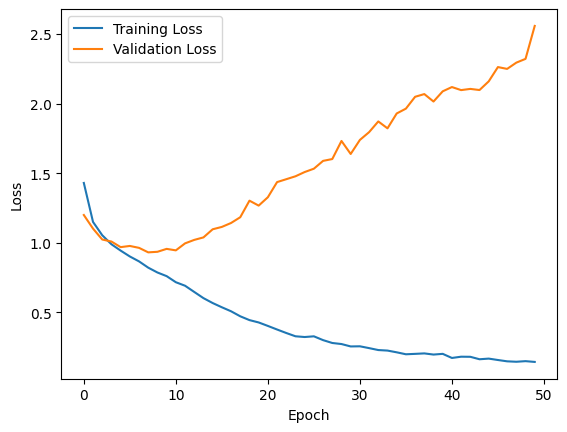

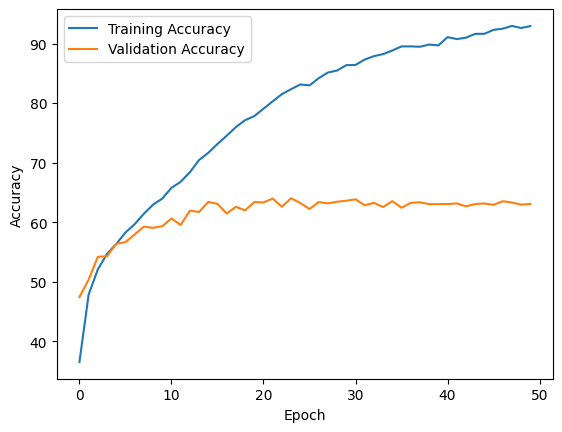

In [15]:
trainset = MFCCDataset(
    csv_file=train_csv, root_dir=root_dir, transform=transform)
valset = MFCCDataset(
    csv_file=val_csv, root_dir=root_dir, transform=transform)
testset = MFCCDataset(
    csv_file=test_csv, root_dir=root_dir, transform=transform)

trainloader = DataLoader(trainset, batch_size=128,
                         shuffle=True, num_workers=8, pin_memory=True)
valloader = DataLoader(valset, batch_size=128,
                       shuffle=False, num_workers=8, pin_memory=True)
testloader = DataLoader(testset, batch_size=128,
                        shuffle=False, num_workers=8, pin_memory=True)

# Label mappings
labelmap = trainset.label_map
print(f"Mapping from Emotion to Number: {labelmap}")

print(f"Model is on: {next(model.parameters()).device}")
model, train_losses, train_accuracies, val_losses, val_accuracies = train_epochs(
    model, trainloader, valloader, criterion, optimizer, device, epochs)
torch.save(model.state_dict(), f'{MODEL}_variables_{epochs}.pt')

# Plots
plot_loss(train_losses, val_losses)
plot_accuracy(train_accuracies, val_accuracies)

Define the function to plot the confusion matrix


In [18]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create figure and axes
    plt.figure(figsize=(10, 8))

    # Create heatmap
    sns.heatmap(cm,
                annot=True,  # Show numbers in cells
                fmt='d',     # Use integer formatting
                cmap='Blues',  # Color scheme
                xticklabels=trainset.label_map.keys(),
                yticklabels=trainset.label_map.keys())

    # Set labels and title
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')

    # Rotate axis labels for better readability
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)

    plt.tight_layout()
    plt.show()

Define the function to evaluate best model on test set


In [19]:
def get_predictions(model, testloader, device, model_path):
    # Load the best model weights
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_preds = []
    all_labels = []
    print("Evaluating best model on test set...")

    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Store predictions for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

Define the function to print out the evaluation metrics


In [20]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report


def get_evaluation_metrics(true_labels, pred_labels, label_map):
    # Compute metrics
    accuracy = accuracy_score(true_labels, pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, pred_labels, average='weighted')

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-score: {f1:.4f}\n")

    # Print detailed classification report
    print(classification_report(true_labels, pred_labels,
          target_names=list(label_map.keys())))

Evaluate the best model on the test set


Evaluating best model on test set...


Testing: 100%|██████████| 75/75 [00:02<00:00, 30.62it/s]


Test Accuracy: 0.6369
Test Precision: 0.6454
Test Recall: 0.6369
Test F1-score: 0.6360

              precision    recall  f1-score   support

       Anger       0.67      0.65      0.66       916
       Bored       0.63      0.84      0.72      1098
     Disgust       0.45      0.51      0.48       291
        Fear       0.35      0.59      0.44       308
       Happy       0.65      0.55      0.60      1914
     Neutral       0.64      0.53      0.58      2226
    Question       0.77      0.76      0.76      1139
         Sad       0.67      0.63      0.65       857
    Surprise       0.62      0.74      0.68       728

    accuracy                           0.64      9477
   macro avg       0.61      0.64      0.62      9477
weighted avg       0.65      0.64      0.64      9477



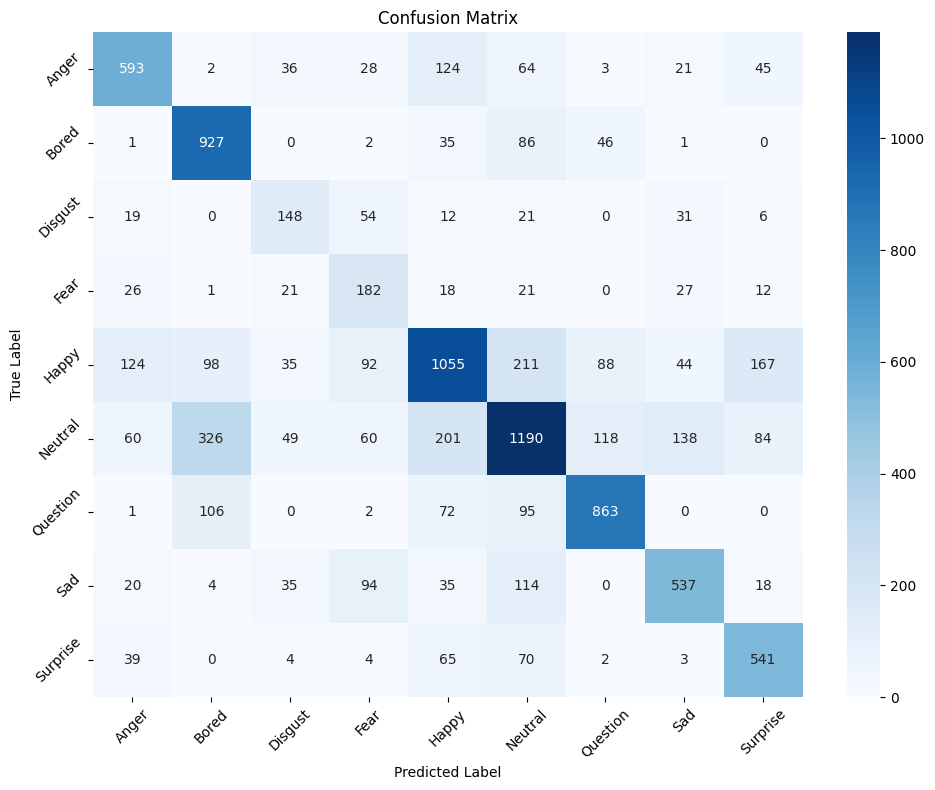

In [21]:
# Load and get predictions from the bets model
best_model_path = f'best_{MODEL}.pt'
all_preds, all_labels = get_predictions(
    model=model,
    testloader=testloader,
    device=device,
    model_path=best_model_path
)

# Print detailed evaluation metrics
get_evaluation_metrics(all_labels, all_preds, labelmap)

# Plot confusion matrix
plot_confusion_matrix(all_labels, all_preds)